In [3]:
import os
import sys
import glob
import random
import numpy as np
import logging
import json
import torch
import math

In [2]:
def transfrom_cam2velo(Tcam):
    R = np.array([7.533745e-03, -9.999714e-01, -6.166020e-04, 1.480249e-02, 7.280733e-04,
                  -9.998902e-01, 9.998621e-01, 7.523790e-03, 1.480755e-02
                  ]).reshape(3, 3)
    t = np.array([-4.069766e-03, -7.631618e-02, -2.717806e-01]).reshape(3, 1)
    cam2velo = np.vstack((np.hstack([R, t]), [0, 0, 0, 1]))

    return Tcam @ cam2velo


def load_poses_from_txt(file_name):
    """
    Modified function from: https://github.com/Huangying-Zhan/kitti-odom-eval/blob/master/kitti_odometry.py
    """
    f = open(file_name, 'r')
    s = f.readlines()
    f.close()
    transforms = {}
    positions = []
    for cnt, line in enumerate(s):
        P = np.eye(4)
        line_split = [float(i) for i in line.split(" ") if i != ""]
        withIdx = len(line_split) == 13
        for row in range(3):
            for col in range(4):
                P[row, col] = line_split[row*4 + col + withIdx]
        if withIdx:
            frame_idx = line_split[0]
        else:
            frame_idx = cnt
        transforms[frame_idx] = transfrom_cam2velo(P)
        positions.append([P[0, 3], P[2, 3], P[1, 3]])
    return transforms, np.asarray(positions)


In [3]:
eval_seq = 0
log3dnet_dir=os.getenv('LOG3DNET_DIR')
revisit_criteria=3
not_revisit_criteria=20
skip_time=30
revisit_json_file = 'is_revisit_D-{}_T-{}.json'.format(
    int(revisit_criteria), int(skip_time))
cd_thresh_min=0.001
cd_thresh_max=1
num_thresholds=1000

## ==== Kitti =====
print("kitti dataset")
kitti_dir= os.getenv('WORK') + '/datas/datasets/'
eval_seq = '%02d' % eval_seq
sequence_path = kitti_dir + 'sequences/' + eval_seq + '/'
_, positions_database = load_poses_from_txt(sequence_path + 'poses.txt')

kitti dataset


In [4]:
min_bbox = np.min(positions_database,0) 
min_bbox

array([-271.2806 ,  -17.60491,  -22.29466])

In [5]:
positions_database = positions_database - min_bbox

In [7]:
positions_database[4540]

array([265.696669, 114.56644 ,  18.731902])

In [10]:
gpsround = 10
def label2gps(label_id) :
    label_id_gps = positions_database[int(label_id)]
    res_str = f'{round(label_id_gps[0]*gpsround):04}' + f'{round(label_id_gps[1]*gpsround):04}'
    return res_str

In [11]:
label2gps(4540) 

'26571146'

In [15]:
gpsround = 10
dictio = {}
for i in range(len(positions_database)):
    print( '%06d' % i, label2gps(i))
    if label2gps(i) in dictio:
        continue
    dictio[label2gps(i)] = '%06d' % i

000000 27130176
000001 27120185
000002 27120193
000003 27110202
000004 27110210
000005 27100219
000006 27100228
000007 27100236
000008 27090245
000009 27090253
000010 27080262
000011 27080270
000012 27070279
000013 27070288
000014 27060296
000015 27060305
000016 27050313
000017 27050322
000018 27040331
000019 27040340
000020 27030349
000021 27030358
000022 27020367
000023 27020376
000024 27010385
000025 27010394
000026 27000404
000027 26990413
000028 26990423
000029 26980432
000030 26980441
000031 26970451
000032 26970461
000033 26960470
000034 26960480
000035 26960490
000036 26950500
000037 26950509
000038 26940519
000039 26940529
000040 26930540
000041 26920550
000042 26920561
000043 26910571
000044 26900581
000045 26900592
000046 26890602
000047 26880612
000048 26870622
000049 26870632
000050 26860642
000051 26860652
000052 26850662
000053 26840672
000054 26830681
000055 26830691
000056 26820701
000057 26820711
000058 26810720
000059 26800730
000060 26800740
000061 26790749
000062 2

sequence_path = '/lustre/fsn1/worksf/projects/rech/dki/ujo91el/datas/datasets/sequences/00/' 
with open(sequence_path + "dict_gps_2_label.json", 'w', encoding ='utf8') as json_file: 
        json.dump(dictio, json_file, allow_nan=False) 
        print("saved dictio", sequence_path + "dict_gps_2_label.json")

In [17]:
gpsround = 100
def label2gps(label_id) :
    label_id_gps = positions_database[int(label_id)]
    xx = round(label_id_gps[0]*gpsround)
    yy = round(label_id_gps[1]*gpsround)
    xx_str = f'{xx:05}'
    yy_str = f'{yy:05}'
    res_str = ''.join(x + y for x, y in zip(xx_str, yy_str))
    res_str += xx_str[len(yy_str):] + yy_str[len(xx_str):]
    return res_str


def gps2position(self,res_str) :
    xx_str = res_str[::2]
    yy_str = res_str[1::2]
    pos = [float(xx_str)/gpsround,float(yy_str)/gpsround,0]
    if gpsstr.isnumeric() and len(gpsstr) == 8:
        return [float(gpsstr[0:4])/gpsround,float(gpsstr[4:8])/gpsround,0]
    else :
        return [0,0,0]

In [18]:
dictio = {}
for i in range(len(positions_database)):
    print( '%06d' % i, label2gps(i))
    if label2gps(i) in dictio:
        continue
    dictio[label2gps(i)] = '%06d' % i

000000 2071172680
000001 2071182436
000002 2071191392
000003 2072101148
000004 2072110094
000005 2072110950
000006 2072120705
000007 2072039651
000008 2072049417
000009 2072058363
000010 2072068119
000011 2072077075
000012 2072077920
000013 2072086776
000014 2072096622
000015 2073005487
000016 2073015334
000017 2073024281
000018 2073034038
000019 2073033977
000020 2073043827
000021 2073052778
000022 2073062619
000023 2073071660
000024 2073081512
000025 2073090465
000026 2074000308
000027 2064919351
000028 2064928296
000029 2064938240
000030 2064947195
000031 2064957140
000032 2064966096
000033 2064976053
000034 2064986000
000035 2064985958
000036 2064995916
000037 2065904964
000038 2065914913
000039 2065923954
000040 2065932999
000041 2065952023
000042 2065961058
000043 2065970191
000044 2065980124
000045 2065899157
000046 2066808189
000047 2066818220
000048 2066827240
000049 2066836280
000050 2066846220
000051 2066855250
000052 2066864188
000053 2066874116
000054 2066883144
000055 206

In [29]:
label_id_gps = positions_database[0]
xx = round(label_id_gps[0]*gpsround)
yy = round(label_id_gps[1]*gpsround)
xx_str = f'{xx:05}'
yy_str = f'{yy:05}'
xx_str, yy_str

('27128', '01760')

In [ ]:
res_str = ''.join(x + y for x, y in zip(xx_str, yy_str))
res_str += xx_str[len(yy_str):] + yy_str[len(xx_str):]

In [26]:
sequence_path = '/lustre/fsn1/worksf/projects/rech/dki/ujo91el/datas/datasets/sequences/00/' 
with open(sequence_path + "dict_gps_2_label_v2.json", 'w', encoding ='utf8') as json_file: 
        json.dump(dictio, json_file, allow_nan=False) 
        print("saved dictio", sequence_path + "dict_gps_2_label_v2.json")

saved dictio /lustre/fsn1/worksf/projects/rech/dki/ujo91el/datas/datasets/sequences/00/dict_gps_2_label_v2.json


In [ ]:
# Opening JSON file
f = open("/lustre/fsn1/worksf/projects/rech/dki/ujo91el/datas/datasets/sequences/00/dict_gps_2_label.json",)
data = json.load(f)
f.close()

data

# share

# verif

# plot 

In [1]:
#https://fr-fr.topographic-map.com/map-kvhv57/Karlsruhe/?center=49.00617%2C8.39701&zoom=16
x = []
z = []
for i in range(len(positions_database2)):
    x.append(i)
    z.append(positions_database2[i][2])

import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(x,z)
plt.xlabel("query ")
plt.ylabel("Altitude ")
ax = fig.gca()
ax.set_xticks(np.arange(min(x), max(x), 300))
plt.grid()
plt.show()

plt.close()

NameError: name 'positions_database2' is not defined

In [3]:
f = open("/lustre/fsn1/worksf/projects/rech/dki/ujo91el/datas/datasets/sequences/00/dict_gps_2_label.json",) # gps xxxxyyyy
#f = open("/lustre/fsn1/worksf/projects/rech/dki/ujo91el/datas/datasets/sequences/00/dict_gps_2_label.json",) # gps xyxyxyxy
data = json.load(f)
f.close()

In [4]:
data


{'27130176': '000000',
 '27120185': '000001',
 '27120193': '000002',
 '27110202': '000003',
 '27110210': '000004',
 '27100219': '000005',
 '27100228': '000006',
 '27100236': '000007',
 '27090245': '000008',
 '27090253': '000009',
 '27080262': '000010',
 '27080270': '000011',
 '27070279': '000012',
 '27070288': '000013',
 '27060296': '000014',
 '27060305': '000015',
 '27050313': '000016',
 '27050322': '000017',
 '27040331': '000018',
 '27040340': '000019',
 '27030349': '000020',
 '27030358': '000021',
 '27020367': '000022',
 '27020376': '000023',
 '27010385': '000024',
 '27010394': '000025',
 '27000404': '000026',
 '26990413': '000027',
 '26990423': '000028',
 '26980432': '000029',
 '26980441': '000030',
 '26970451': '000031',
 '26970461': '000032',
 '26960470': '000033',
 '26960480': '000034',
 '26960490': '000035',
 '26950500': '000036',
 '26950509': '000037',
 '26940519': '000038',
 '26940529': '000039',
 '26930540': '000040',
 '26920550': '000041',
 '26920561': '000042',
 '26910571'

In [22]:
f = open("/lustre/fsn1/worksf/projects/rech/dki/ujo91el/datas/datasets/sequences/00/dict_gps_2_label_v2.json",) # gps xxxxyyyy
#f = open("/lustre/fsn1/worksf/projects/rech/dki/ujo91el/datas/datasets/sequences/00/dict_gps_2_label.json",) # gps xyxyxyxy
data = json.load(f)
f.close()

In [23]:
data

{'2071172680': '000000',
 '2071182436': '000001',
 '2071191392': '000002',
 '2072101148': '000003',
 '2072110094': '000004',
 '2072110950': '000005',
 '2072120705': '000006',
 '2072039651': '000007',
 '2072049417': '000008',
 '2072058363': '000009',
 '2072068119': '000010',
 '2072077075': '000011',
 '2072077920': '000012',
 '2072086776': '000013',
 '2072096622': '000014',
 '2073005487': '000015',
 '2073015334': '000016',
 '2073024281': '000017',
 '2073034038': '000018',
 '2073033977': '000019',
 '2073043827': '000020',
 '2073052778': '000021',
 '2073062619': '000022',
 '2073071660': '000023',
 '2073081512': '000024',
 '2073090465': '000025',
 '2074000308': '000026',
 '2064919351': '000027',
 '2064928296': '000028',
 '2064938240': '000029',
 '2064947195': '000030',
 '2064957140': '000031',
 '2064966096': '000032',
 '2064976053': '000033',
 '2064986000': '000034',
 '2064985958': '000035',
 '2064995916': '000036',
 '2065904964': '000037',
 '2065914913': '000038',
 '2065923954': '000039',


In [28]:
data['2067767873']

'000063'

In [4]:
f = open("/lustre/fsn1/worksf/projects/rech/dki/ujo91el/datas/datasets/sequences/00/hierarchical.json",) # gps xxxxyyyy
#f = open("/lustre/fsn1/worksf/projects/rech/dki/ujo91el/datas/datasets/sequences/00/dict_gps_2_label.json",) # gps xyxyxyxy
data = json.load(f)
f.close()

In [8]:
list(data.keys())[0]

'0'

In [25]:
#https://fr-fr.topographic-map.com/map-kvhv57/Karlsruhe/?center=49.00617%2C8.39701&zoom=16
x = []
z = []
for i in range(len(data)):
    b = list(data.keys())[i]
    x.append(int(b))
    z.append(int(data[b]))

x0, y0 = zip(*sorted(zip(x, z)))

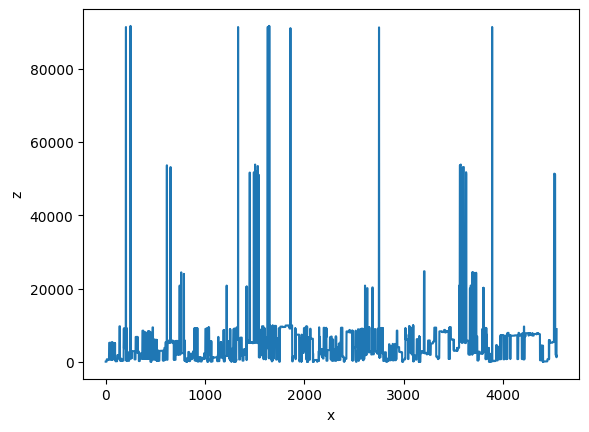

In [26]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(x0,y0)
plt.xlabel("x")
plt.ylabel("z")
plt.show()

In [23]:
y0

('000070',
 '000071',
 '000072',
 '000073',
 '000074',
 '000075',
 '000076',
 '000077',
 '000078',
 '000079',
 '000710',
 '000711',
 '000712',
 '000713',
 '000590',
 '000591',
 '000592',
 '000593',
 '000594',
 '000595',
 '000596',
 '000597',
 '000598',
 '000599',
 '000520',
 '000521',
 '000522',
 '000523',
 '000524',
 '000525',
 '000526',
 '000527',
 '000528',
 '000529',
 '005210',
 '005211',
 '005212',
 '005213',
 '005214',
 '005215',
 '005216',
 '005217',
 '005218',
 '005219',
 '005220',
 '005221',
 '005222',
 '005223',
 '005224',
 '005225',
 '005226',
 '005227',
 '000540',
 '000541',
 '000542',
 '000543',
 '000544',
 '000545',
 '000546',
 '000547',
 '000548',
 '000549',
 '005410',
 '005411',
 '005412',
 '005413',
 '005414',
 '005415',
 '000580',
 '000581',
 '000582',
 '000583',
 '005130',
 '005131',
 '005132',
 '005133',
 '005134',
 '005135',
 '005136',
 '005137',
 '005138',
 '005170',
 '005171',
 '005139',
 '005110',
 '005111',
 '005112',
 '005113',
 '005114',
 '005115',
 '005116',

In [2]:
import os
import sys
import glob
import random
import numpy as np
import logging
import json
import torch
import math

In [4]:

torch.load("/lustre/fsn1/worksf/projects/rech/dki/ujo91el/datas/datasets/sequences/00/logg_desc/000000.pt")

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.